In [ ]:
#| hide
#| default_exp planner
from nbdev import *

# Temperature scan planner

In [ ]:
#| export
from ase.build import bulk
import ase.units as un
from scipy import stats
from matplotlib import pylab as plt
import numpy as np
import itertools
from tqdm.auto import tqdm
# from rich.progress import track

In [ ]:
#| exporti
flatten = itertools.chain.from_iterable

In [ ]:
#| export
def plan_T_scan(Tlo, Thi, nat, N=1, plot_dist=True):
    l = Tlo
    # 1/sqrt(2) adjusts for the shape of the distribution 
    # generated by the HECSS.smple function.
    n = np.sqrt(3*nat/2/2) 
    s0 = l/n
    s = s0
    assert n>1
    a = (n+1)/(n-1)
    r = []
    while l <= Thi:
        sf = s 
        if l * a > Thi:
            sf *= 1.12
        
        r.append([l, s, sf/s0])
        l *= a
        s = l/n
    ns = 1
    frm = "N=%.1f"
    if N > 1 :
        ns = N/r[-1][-1]
        frm = "N=%.0f"
        r = [[l, s, int(round(ns*sf))] for l, s, sf in r]
    frm = frm + " T=%.0fK"
    if plot_dist:
        f = stats.norm.pdf
        x = np.linspace(Tlo*(1-3/n), Thi*(1+3/n), 600)
        y = np.zeros(x.shape)
        for c, (l, s, sf) in enumerate(r):
            p = sf*f(x, l, s)
            # plt.axvline(l-l/n, ymax=0.5, lw=1, ls='-', color=f'C{c}')
            # plt.axvline(l+l/n, ymin=0.5, lw=1, ls='-', color=f'C{c}')
            plt.plot(x, p, label=(frm % (sf, l))) #f'N={sf*ns:.1f} T={l:.0f}K'
            y += p
        plt.plot(x, y)
        plt.legend(loc='upper right')
        plt.xlabel('Temperature')
        plt.ylabel('Relative density')
        plt.title('Temperature scan. N=relative number of samples')
    return r

## Simulate with `stats.normal` random variable

  0%|          | 0/4 [00:00<?, ?it/s]

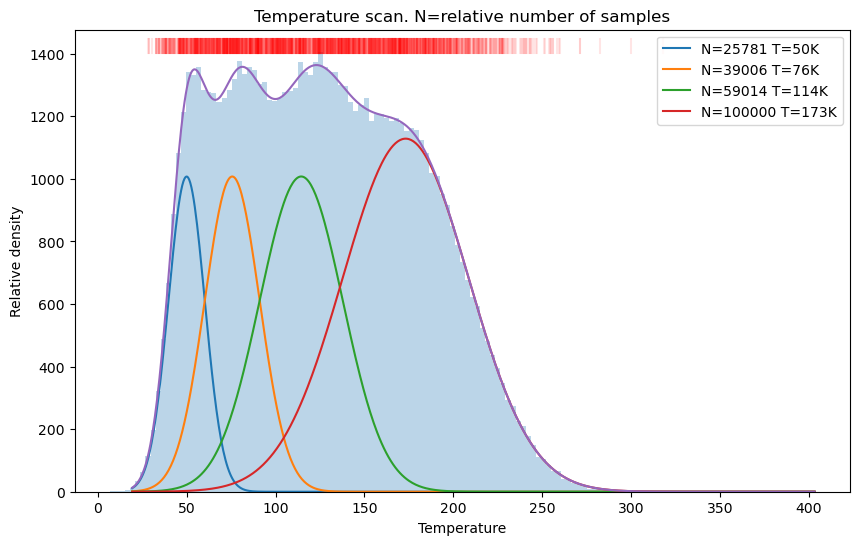

In [ ]:
# semilogx()
plt.figure(figsize=(10,6))
rv = stats.norm
N = 100_000
plan = plan_T_scan(50, 250, 32, N)

el = np.zeros(0)
for c, (l, s, n) in enumerate(tqdm(plan)):
    el = np.append(el, rv.rvs(loc=l, scale=s, size=n))

skip = len(el)//2000
skip = int(max(1, skip))
for s in el[::skip]:
    plt.axvline(s, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.1)
    
NF = sum([sf for _, _, sf in plan])
counts, bins = np.histogram(el, bins='auto', density=True)
plt.hist(bins[:-1], bins, weights=NF*counts, color='C0', alpha=0.3);

## Run with `HECSS` sampler

In [ ]:
#| asap
import asap3
from hecss import HECSS
from hecss.util import select_asap_model
from hecss.optimize import make_sampling
from hecss.monitor import plot_stats

In [ ]:
#| asap
model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '3x3x3'
sc = [int(v) for v in sys_size.split('x')]

cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(asap3.OpenKIMcalculator(model))
hecss = HECSS(cryst, lambda : asap3.OpenKIMcalculator(model), pbar=False)
hecss.estimate_width_scale(10, Tmax=1000);

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


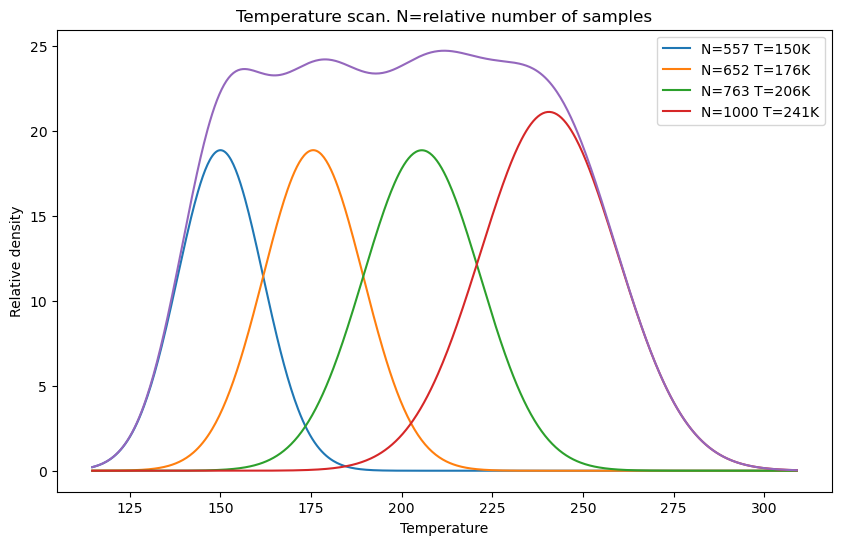

In [ ]:
#| asap
N = 1_000
plt.figure(figsize=(10,6))
plan = plan_T_scan(150, 250, len(cryst), N)

In [ ]:
#| asap
smpls = {}
for T, sig, n in tqdm(plan):
    # sampler = HECSS_Sampler(cryst, asap3.OpenKIMcalculator(model),
    #                         T, N=int(n), pbar=tqdm(total=n))
    smpls[T]=np.array([s[-1] for s in hecss._sampler(T, n)])
# ell = [np.array([s[-1] for s in sl]) for sl in smpls.values()]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#| asap

ell = np.concatenate(list(smpls.values()))
e_min = ell.min()
e_max = ell.max()

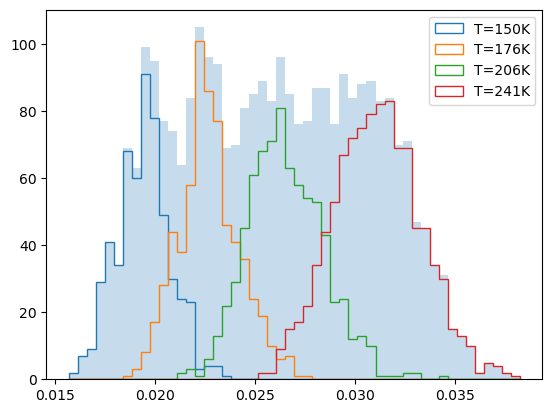

In [ ]:
#| asap

for T, el in smpls.items():
    plt.hist(el, bins=50, histtype='step', label=f'{T=:.0f}K', range=(e_min, e_max))
plt.hist(ell, bins=50, stacked=True, color='C0', alpha=0.25, range=(e_min, e_max))
plt.legend();

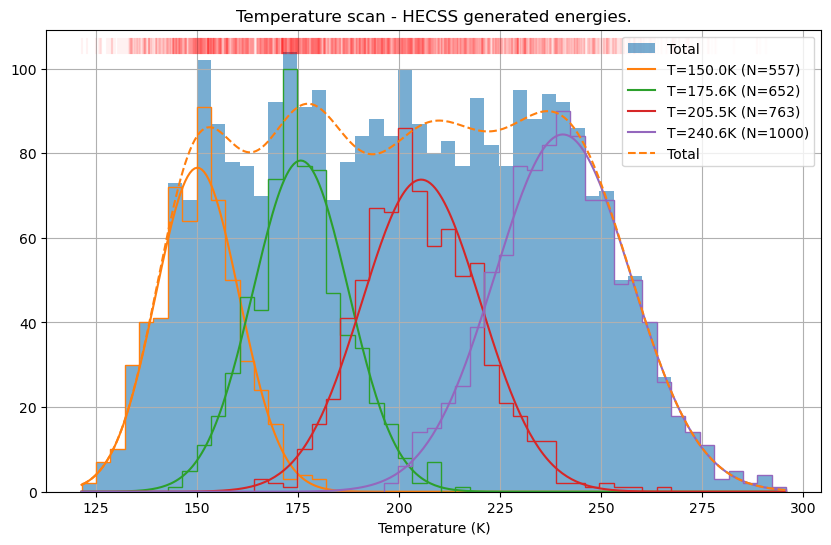

In [ ]:
#| asap
plt.figure(figsize=(10,6))
if N < 10_000:
    bins = np.linspace(e_min, e_max, 50)*2/un.kB/3
else :
    bins = 'auto'
cnt, bins, _ = plt.hist(ell*2/un.kB/3, 
                     bins=bins, density=False, alpha=0.6, label='Total');
x = np.linspace(bins[0], bins[-1], 300)
y = np.zeros(x.shape)
tdx = bins[1]-bins[0]
for c, ((T, el), (Tp, sig, n)) in enumerate(zip(smpls.items(), plan)):
    # bins = 'auto'
    e = el*2/un.kB/3
    Tc, Tb, _ = plt.hist(e, bins=bins, density=False, 
                         histtype='step', color=f'C{c+1}');
    dx = Tb[1]-Tb[0]
    # plt.plot(x, dx*n*stats.norm.pdf(x, loc=T, scale=sig), color=f'C{c+1}', 
    #          label=f'{T=:.1f}K (N={int(Tc.sum())})')
    # y += tdx*n*stats.norm.pdf(x, loc=T, scale=sig)

    fit = stats.norm.fit(e)
    plt.plot(x, dx*n*stats.norm.pdf(x, *fit), color=f'C{c+1}',
             label=f'{T=:.1f}K (N={int(Tc.sum())})')
    
    y += tdx*n*stats.norm.pdf(x, *fit)
    
    skip = len(el)//500
    skip = max(1, skip)
    for v in e[::skip]:
        plt.axvline(v, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.05)
    
plt.plot(x, y, '--', label='Total')
plt.xlabel('Temperature (K)')
plt.legend(loc='upper right')
plt.title('Temperature scan - HECSS generated energies.')
plt.grid()
plt.savefig(f'AUX/T_scan_{N=}.pdf')

## Test temperature scanning planner

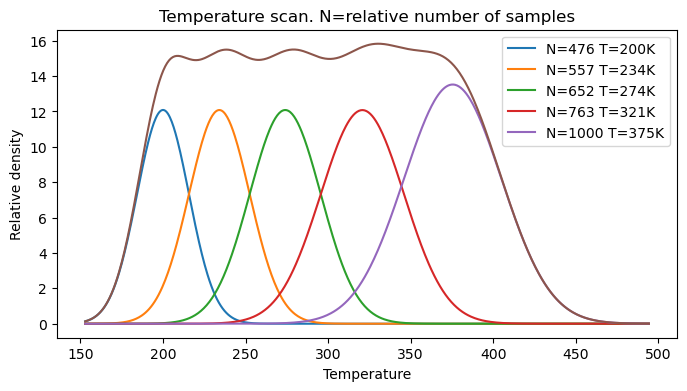

In [ ]:
#| asap
N = 1000
plt.figure(figsize=(8,4))
plan = plan_T_scan(200, 400, len(cryst), N)
plt.savefig('AUX/T_scan_plan.pdf', bbox_inches='tight')

In [ ]:
#| asap
smpll = []
for T, sig, n in tqdm(plan):
    smpll.append([s for s in hecss.sample(T, n)])
ell = [[s[-1] for s in sl] for sl in smpll]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#| asap

usmp = []
for sl in smpll:
    usmp += sl

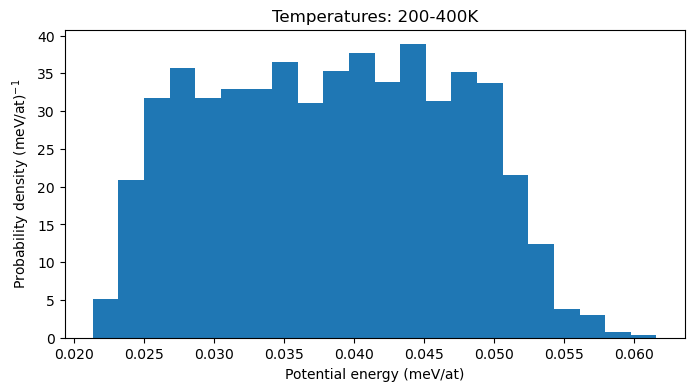

In [ ]:
#| asap

plt.figure(figsize=(8,4))
plt.hist([s[-1] for s in usmp], bins='auto', density=True)
plt.xlabel('Potential energy (meV/at)')
plt.ylabel('Probability density (meV/at)$^{-1}$')
plt.title('Temperatures: 200-400K')
plt.savefig(f'AUX/uniform.pdf', bbox_inches='tight')

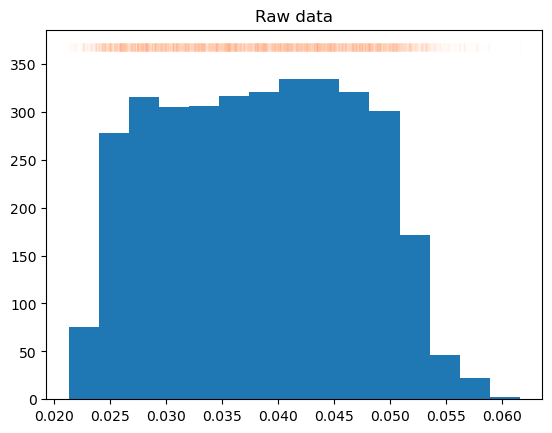

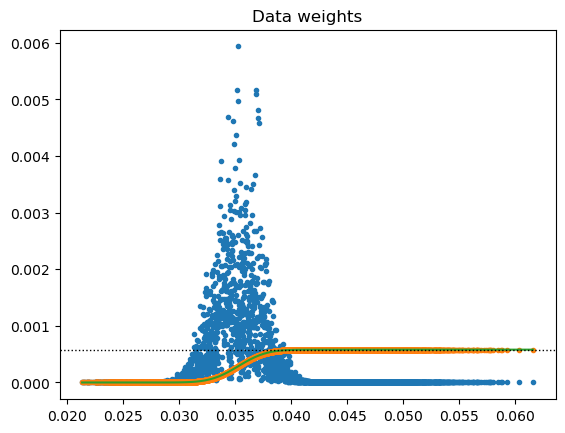

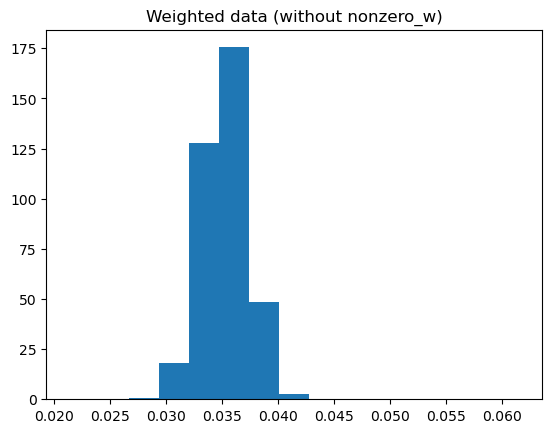

1
3448 3943


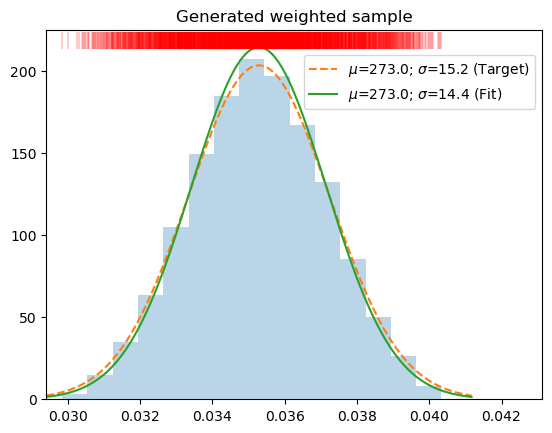

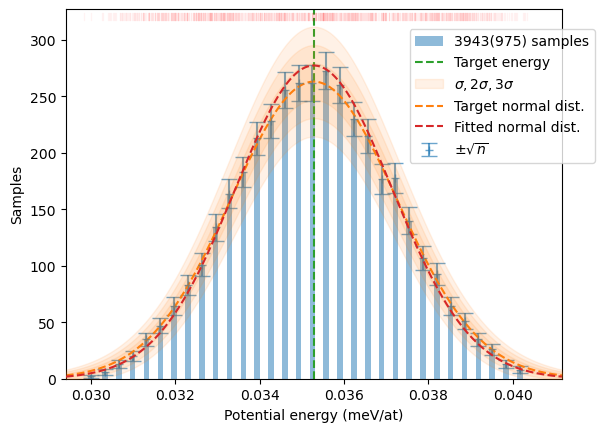

In [ ]:
#| asap

T = 273
wd = make_sampling(usmp, T, N=4*N, nonzero_w=False, debug=True)
print(len(usmp), len(wd))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))
plt.show();
plot_stats(wd, T, sqrN=True, show=False)
plt.savefig(f'AUX/T_scan_{T=:.0f}K.pdf', bbox_inches='tight')

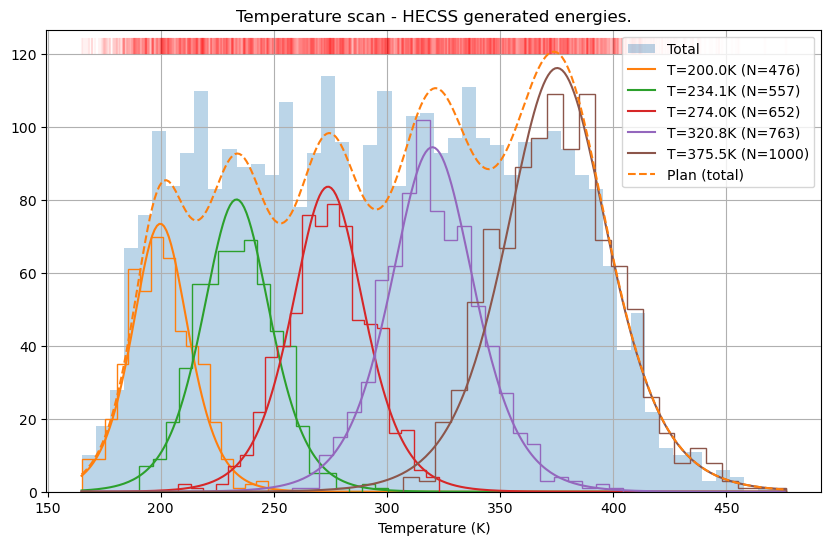

In [ ]:
#| asap
plt.figure(figsize=(10,6))
if N < 1_000:
    bins = np.linspace(min(flatten(ell)), max(flatten(ell)), 40)*2/un.kB/3
else :
    bins = 'auto'
cnt, bins, _ = plt.hist(np.array(list(flatten(ell)))*2/un.kB/3, 
                     bins=50, density=False, alpha=0.3, label='Total');
x = np.linspace(bins[0], bins[-1], 300)
y = np.zeros(x.shape)
tdx = bins[1]-bins[0]
for c, (el, (T, sig, n)) in enumerate(zip(ell, plan)):
    e = np.array(el)
    bins = 'auto'
    Tc, Tb, _ = plt.hist(e*2/un.kB/3, bins=bins, density=False, 
                         histtype='step', color=f'C{c+1}');
    dx = Tb[1]-Tb[0]
    nf = np.sum(Tc)*dx
    # plt.plot(x, dx*n*stats.norm.pdf(x, loc=T, scale=sig), color=f'C{c+1}', 
    #          label=f'{T=:.1f}K (N={int(Tc.sum())})')
    # y += tdx*n*stats.norm.pdf(x, loc=T, scale=sig)
    fit = stats.logistic.fit(e*2/un.kB/3)
    plt.plot(x, nf*stats.logistic.pdf(x, *fit), color=f'C{c+1}', 
             label=f'{T=:.1f}K (N={int(Tc.sum())})')
    y += nf*stats.logistic.pdf(x, *fit)

    skip = len(el)//1000
    skip = max(1, skip)
    for v in e[::skip]*2/un.kB/3:
        plt.axvline(v, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.05)
    
plt.plot(x, y, '--', label='Plan (total)')
plt.xlabel('Temperature (K)')
plt.legend(loc='upper right')
plt.title('Temperature scan - HECSS generated energies.')
plt.grid()
plt.savefig(f'AUX/T_scan_{N=}.pdf')

<matplotlib.lines.Line2D>

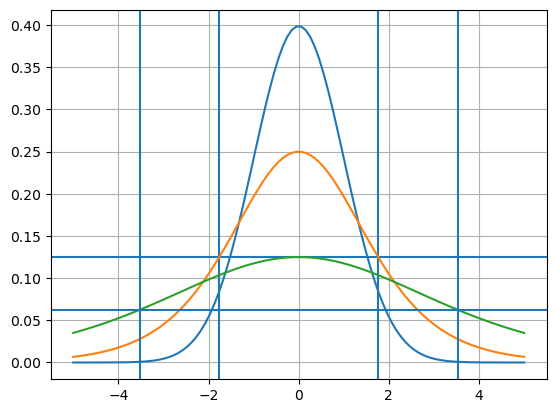

In [ ]:
x = np.linspace(-5, 5, 100)
plt.plot(x, stats.norm.pdf(x))
plt.grid()
plt.axhline(1/8)
plt.axvline(np.log(3+2*np.sqrt(2)))
plt.axvline(np.log(3-2*np.sqrt(2)))
plt.plot(x, stats.logistic.pdf(x))
s=2
plt.plot(x, stats.logistic.pdf(x, scale=s))
plt.axhline(1/(8*s))
plt.axvline(s*np.log(3+2*np.sqrt(2)))
plt.axvline(s*np.log(3-2*np.sqrt(2)))

<matplotlib.lines.Line2D>

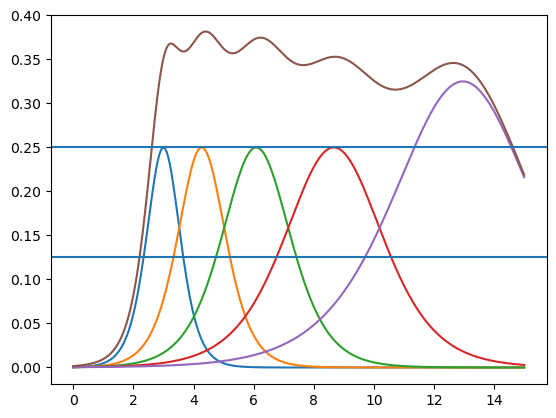

In [ ]:
x = np.linspace(0, 15, 300)
y = np.zeros(x.shape)
a = np.log(3+2*np.sqrt(2))
a = 1.4
x0 = 3
b = 1/8
nf = 1
while x0 < 15:
    s = x0*b
    if x0*(1+b*a)/(1-b*a) > 15:
        nf = 1.3
        x0 *= 1.05
    yy=nf*s*stats.logistic.pdf(x, loc=x0, scale=s)
    plt.plot(x,yy)
    y += yy
    x0 *= (1+a*b)/(1-a*b)
plt.plot(x,y)
plt.axhline(1/4); plt.axhline(1/8)

  0%|          | 0/4 [00:00<?, ?it/s]

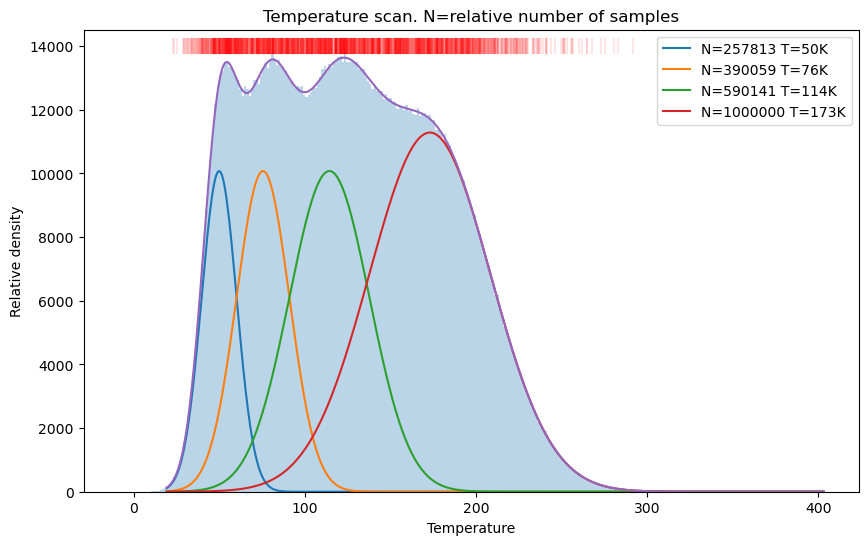

In [ ]:
# semilogx()
plt.figure(figsize=(10,6))
rv = stats.norm
N = 1_000_000
plan = plan_T_scan(50, 250, 32, N)

el = np.zeros(0)
for c, (l, s, n) in enumerate(tqdm(plan)):
    el = np.append(el, rv.rvs(loc=l, scale=s, size=n))

skip = len(el)//2000
skip = int(max(1, skip))
for s in el[::skip]:
    plt.axvline(s, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.1)
    
NF = sum([sf for _, _, sf in plan])
counts, bins = np.histogram(el, bins='auto', density=True)
plt.hist(bins[:-1], bins, weights=NF*counts, color='C0', alpha=0.3);